In [4]:
import cv2
import numpy as np
import csv
import matplotlib.pyplot as plt
import statistics as stat

import tifffile as tif

# Background Estimation

In [3]:
filename = "video4.avi"
location = "E:/Sawani/data/210318/F1 control block 1/"
length = 700

count = 0
random = np.random.randint(400, length, 75)

bg_frames = [] #stores frames to used for bg calculation

cap = cv2.VideoCapture(location + filename)

while cap.isOpened:
    
    ret,frame = cap.read()
    
    if ret == 0:
        break
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(frame, (1,1), 0)
    _, thresh = cv2.threshold(blur, 90, 255, cv2.THRESH_BINARY_INV) 
    
    if count == length:
        break
        
    if count in random:
        copy = frame.copy()
        bg_frames.append(copy)
    
    cv2.imshow("frame", thresh)  
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    count += 1
    
cap.release()
cv2.destroyAllWindows()

bg_frames = np.array(bg_frames)
bg = np.median(bg_frames, axis = 0)
bg = cv2.convertScaleAbs(bg)
cv2.imshow('Background', bg)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
tif.imsave(location+filename.split('.avi')[0]+'.tif',bg)

In [6]:
frame.shape

(1018, 1072)

# Motion Detection

In [36]:
cap = cv2.VideoCapture(location + filename)

count = 0
random = np.random.randint(0, 500, 25)

bg_frames = [] #stores frames to used for bg calculation
x_coor = []
y_coor = []

while cap.isOpened:
    
    ret,frame = cap.read()
    
    if ret == 0:
        break
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(frame, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 90, 255, cv2.THRESH_BINARY_INV)
    fg = thresh - bg
    
    #_,thresh = cv2.threshold(fg, 50, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((2,2),np.uint8)
    erode = cv2.erode(fg, kernel, iterations = 1)
    kernel = np.ones((5,5),np.uint8)
    dilate = cv2.dilate(erode, kernel, iterations = 5)
    
    _, contours, _ = cv2.findContours(erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest = max(contours, key = cv2.contourArea)
    
    (x,y),radius = cv2.minEnclosingCircle(largest)
    center = (int(x),int(y))
    radius = int(radius)
    cv2.circle(frame, center, 5, 5)
    x_coor.append(int(x))
    y_coor.append(int(y))
    
    for i in range(len(x_coor) - 1):
        cv2.circle(frame, (x_coor[i], y_coor[i]), 2, -1)
    
    
    cv2.imshow("frame", frame)  
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    count += 1
    
cap.release()
cv2.destroyAllWindows()

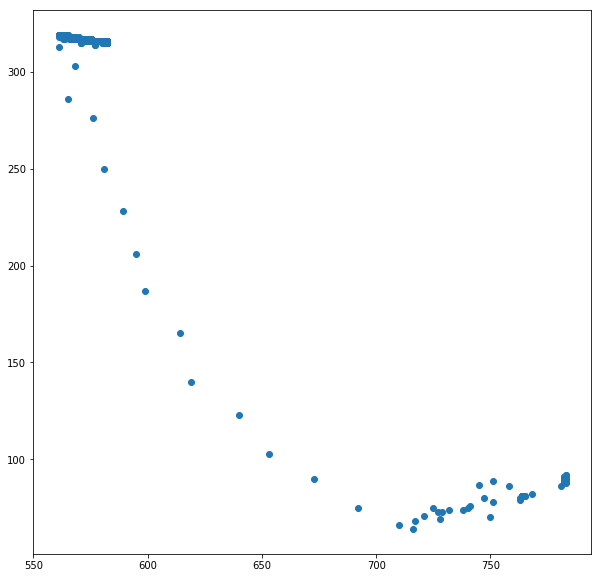

In [37]:
plt.figure(figsize = (10, 10))
plt.scatter(x_coor, y_coor)

output = [x_coor, y_coor]
fields = ["x","y"]

with open(location + filename[:-4] + "coordinates.csv", "w") as csv_file:
    csvwriter = csv.writer(csv_file)
    csvwriter.writerow(fields)
    for i in range(len(output[0])):
        csvwriter.writerow([output[0][i], output[1][i]])

In [24]:
dist = []
vel = []

for i in range(len(x_coor) - 1):
    distance = ((x_coor[i + 1] - x_coor[i])**2 + (y_coor[i + 1] - y_coor[i])**2)**0.5
    if distance <= 2:
        dist.append(0)
    else:
        dist.append(distance)
    #if i != 0:
        #dist[-1] += dist[-2]

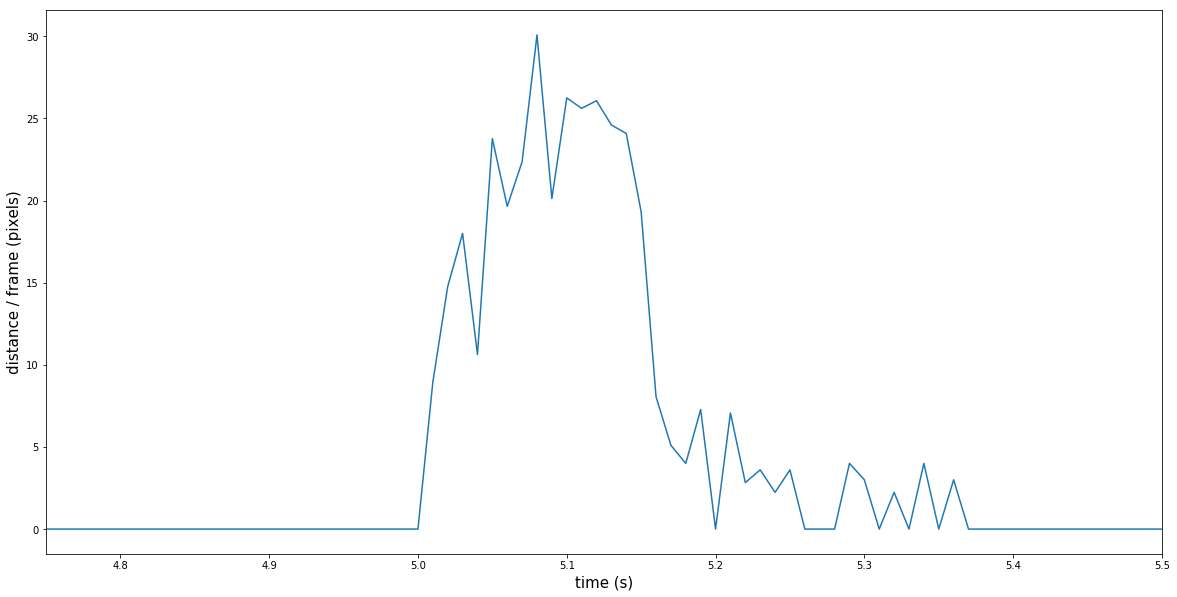

In [30]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(0, 10, 0.01), dist[:1000])
plt.xlabel("time (s)", fontsize = 15)
plt.ylabel("distance / frame (pixels)", fontsize = 15)
plt.xlim(4.75, 5.5)
plt.savefig("./dist_time_plot.png")

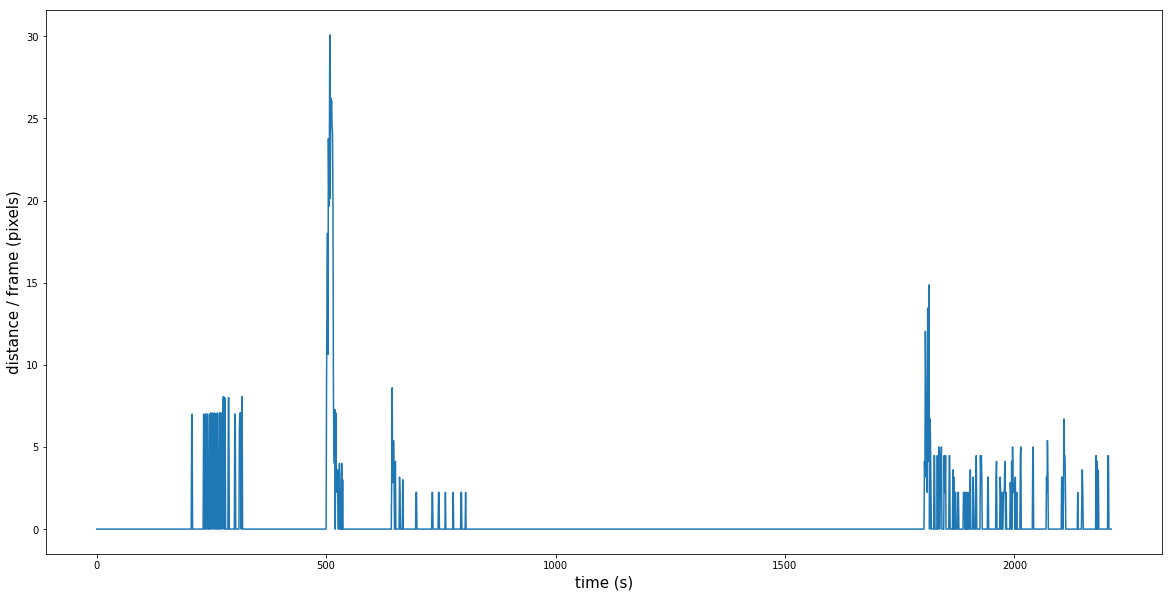

In [27]:
plt.figure(figsize = (20, 10))
plt.plot(dist[:])
plt.xlabel("time (s)", fontsize = 15)
plt.ylabel("distance / frame (pixels)", fontsize = 15)
#plt.xlim(5, 5.25)
plt.savefig("./dist_time_plot.png")